# Check noise propagation to source plane and starlet space

In [1]:
__author__ = 'aymgal'
import os
import sys
import copy
import time
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pf
import pysap

import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
import lenstronomy.Util.util as lenstro_util
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Util import kernel_util

from lenstronomy.ImSim.image_sparse_solve import ImageSparseFit
from slitronomy.Util.util import dirac_impulse
from slitronomy.Util.plot_util import nice_colorbar

%matplotlib inline

perfect_seeing = False

np.random.seed(42)

In [2]:
lin_scale = lambda x: x
log_scale = lambda x: np.log10(x)
sqrt_scale = lambda x: np.sqrt(x)

## Setup sparse solver

In [3]:
# data specifics
num_pix = 99  # cutout pixel size
delta_pix = 0.08  # pixel size in arcsec (area per pixel = deltaPix**2)

background_rms = 0.05  # background noise per pixel
#exp_time = 400  # exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)

psf_fwhm = 0.2  # full width half max of PSF, in delta_pix units
psf_num_pix = 41

In [4]:
# data specification (coordinates, etc.)
_, _, ra_at_xy_0, dec_at_xy_0, _, _, Mpix2coord, _ \
    = lenstro_util.make_grid_with_coordtransform(numPix=num_pix, deltapix=delta_pix, subgrid_res=1, 
                                                 inverse=False, left_lower=False)

kwargs_data = {
    'background_rms': background_rms,
    #'exposure_time': exp_time,  # individual exposure time/weight per pixel
    'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0, 
    'transform_pix2angle': Mpix2coord,
    'image_data': np.zeros((num_pix, num_pix))
}
data_class = ImageData(**kwargs_data)

(41, 41)


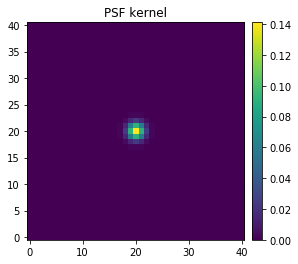

In [5]:
# PSF specification
if perfect_seeing:
    kwargs_psf = {'psf_type': 'NONE'}
else:
    psf_kernel = kernel_util.kernel_gaussian(psf_num_pix, delta_pix, psf_fwhm)
    print(psf_kernel.shape)
    kwargs_psf = {'psf_type': 'PIXEL', 'kernel_point_source': psf_kernel}
    #kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': psf_fwhm, 'pixel_size': delta_pix, 'truncation': 11}
psf_class = PSF(**kwargs_psf)

plt.title("PSF kernel")
im = plt.imshow(psf_class.kernel_point_source, origin='lower')
nice_colorbar(im)
plt.show()

In [6]:
lens_model_list = ['SPEMD']
kwargs_spemd = {'theta_E': 2, 'gamma': 2, 'center_x': 0, 'center_y': 0, 'e1': 0.1, 'e2': -0.2}
kwargs_lens = [kwargs_spemd]#, kwargs_shear]
lens_model_class = LensModel(lens_model_list=lens_model_list)

# list of source light profiles
# get an pre-processed source galaxy from galsim
galsim_index = 31
galsim_data_path = ('../notebooks/data/ring_sims/sims_SNR500/simring_galsim{}_all.pkl'.format(galsim_index))
[data, truth, lens_model] = pkl.load(open(galsim_data_path, 'rb'))
galsim_source_highres = truth['source_galsim_3']
galsim_num_pix = data['num_pix']
galsim_delta_pix = data['delta_pix']
source_model_list = ['INTERPOL']
factor = 2
kwargs_interpol_source = {'image': galsim_source_highres, 'amp': 3000, 'center_x': -0.1, 'center_y': -0.1, 'phi_G': np.pi/8., 
                          'scale': galsim_delta_pix/3. * factor}
kwargs_source = [kwargs_interpol_source]
source_model_class = LightModel(light_model_list=source_model_list)

# list of lens light profiles
lens_light_model_list = []
kwargs_lens_light = [{}]
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)

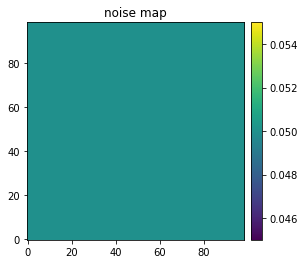

In [7]:
kwargs_numerics = {'supersampling_factor': 3, 'supersampling_convolution': False}

# get the simalated lens image (i.e. image plane)
imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class, 
                        lens_light_model_class, point_source_class=None, 
                        kwargs_numerics=kwargs_numerics)

image_sim_no_noise = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light, kwargs_ps=None)

bkg = image_util.add_background(image_sim_no_noise, sigma_bkd=background_rms)
#poisson = image_util.add_poisson(image_sim_no_noise, exp_time=exp_time)
noise = bkg # + poisson
image_sim = image_sim_no_noise + noise
image_sim_1d = lenstro_util.image2array(image_sim)

kwargs_data['image_data'] = image_sim
if kwargs_data.get('exposure_time', None) is None:
    kwargs_data['noise_map'] = background_rms * np.ones_like(image_sim)
data_class = ImageData(**kwargs_data)

plt.title("noise map")
im = plt.imshow(np.sqrt(data_class.C_D), origin='lower')
nice_colorbar(im)
plt.show()

INFO : source grid has been reduced from 198 to 138 side pixels
TIME build F: 0.05628085136413574
TIME spectral norms: 0.07236194610595703
TIME noise levels: 0.016544103622436523


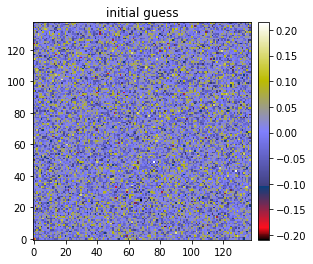

=== iteration 0-0 === : loss+reg = 127.2490|nan, red-chi2 = 8.8892|nan, step_diff = 50.3656|nan


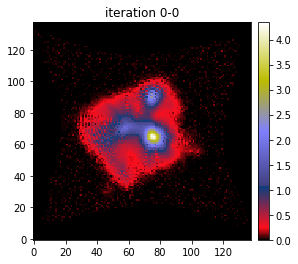

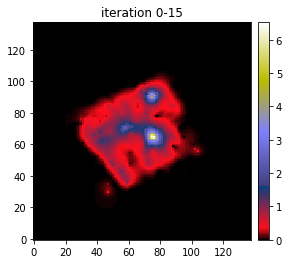

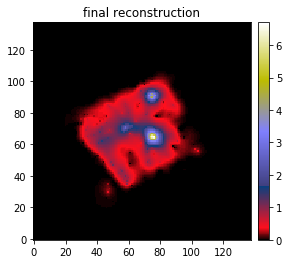

In [8]:
subgrid_res_source = 2

source_model_list_sparsefit = ['STARLETS']
kwargs_starlets_source = {'n_scales': 6}
kwargs_source_sparsefit = [kwargs_starlets_source]
source_model_class_sparsefit = LightModel(light_model_list=source_model_list_sparsefit)

kwargs_special_sparsefit = {
    'delta_x_source_grid': 0,
    'delta_y_source_grid': 0,
}

kwargs_sparse_solver = {
    'source_interpolation': 'bilinear',
    
    'subgrid_res_source': subgrid_res_source,
    'minimal_source_plane': True,
    'min_num_pix_source': 69,
    
    'formulation': 'analysis',
    'force_positivity': True,
    'sparsity_prior_norm': 1,
    'max_threshold': 3,
    'max_threshold_high_freq': 4,
    'num_iter_source': 30,
    'num_iter_weights': 1,
    'verbose': True,
    'show_steps': True,
}

imageSparseFit = ImageSparseFit(data_class, psf_class=psf_class, 
                                lens_model_class=lens_model_class,
                                source_model_class=source_model_class_sparsefit,
                                likelihood_mask=None,
                                kwargs_sparse_solver=kwargs_sparse_solver)

model, model_error, param = imageSparseFit.image_sparse_solve(kwargs_lens, 
                                                       kwargs_source=kwargs_source_sparsefit,
                                                       kwargs_lens_light=None,
                                                       kwargs_special=kwargs_special_sparsefit)

sparseSolver = imageSparseFit.sparseSolver

## Check noise propagation

0 0.0013618922302516682 0.07252073941445314
1 0.0009360745447578318 0.01633627203225467
2 0.00046787269892714243 0.006959474045609886
3 0.000264160292763408 0.003270592514507847
4 0.0002452090007531239 0.0015420234769693319
5 0.00017919124650482598 0.0008875540692071808


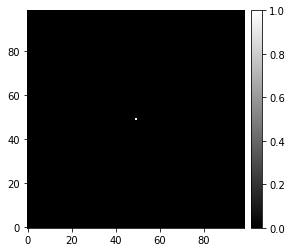

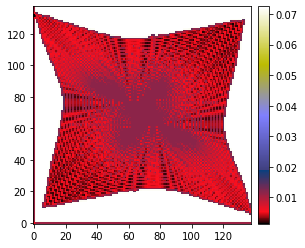

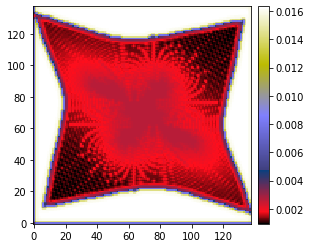

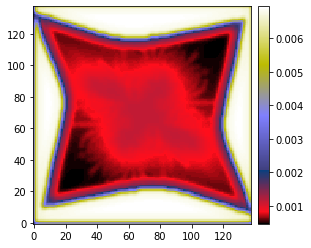

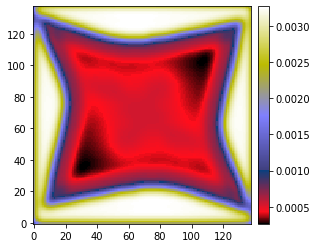

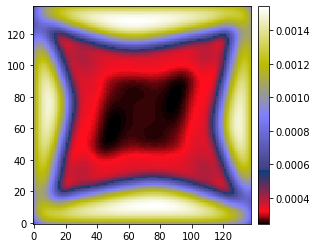

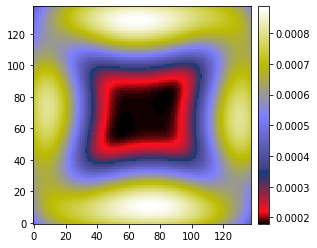

In [9]:
dirac = dirac_impulse(num_pix)
plt.figure()
im = plt.imshow(dirac, origin='lower', cmap='gray')
nice_colorbar(im)

noise_levels = sparseSolver.noise.levels_source
for l in range(noise_levels.shape[0]):
    plt.figure()
    print(l, np.min(noise_levels[l, :, :]), np.max(noise_levels[l, :, :]))
    im = plt.imshow(noise_levels[l, :, :], origin='lower', cmap='gist_stern')
    nice_colorbar(im)